In [52]:
import matplotlib.pyplot as plt
import sys
import torch
sys.path.append("../src")
from interpret import Abs_interpreter
from domain import Interval

In [2]:
# Class to handle interval domain operations
class IntervalDomainHandler():
    def add(self, i1, i2):
        return (i1[0]+i2[0], i1[1]+i2[1])
    
    def subtract(self, i1, i2):
        return (i1[0]-i2[1], i1[1]-i2[0])
    
    def mul(self, i1, i2):
        op1 = i1[0] * i2[0]
        op2 = i1[0] * i2[1]
        op3 = i1[1] * i2[0]
        op4 = i1[1] * i2[1]
        
        return (min(op1, op2, op3, op4), max(op1, op2, op3, op4))

In [5]:
def compute_pinn_burgers_residual_bounds(model_name, 
                                         inpx_range = (-1 + 0.001, 1 - 0.001), 
                                         inpt_range = (0 + 0.001, 2 - 0.001), 
                                         abstract_domain = 'Interval'):
    """
    Takes in a pinn burgers model, input range and the abstract domain.
    Computes the residual bound of the model on that input range using the specified abstract domain.
    """
    model = torch.load(model_name)
    
    if abstract_domain == 'Interval':
        domain = Interval()
    else:
        raise NotImplementedError("Unknown abstract domain: " + domain)
        
    abs_interpreter = Abs_interpreter(model, domain)
    lows = torch.tensor([inpx_range[0], inpt_range[0]]).reshape(-1,1)
    highs = torch.tensor([inpx_range[1], inpt_range[1]]).reshape(-1,1)
    val_bounds, deriv_bounds = abs_interpreter.forward_pass(lows, highs)

    ul = val_bounds[0][0][0].item()
    ur = val_bounds[1][0][0].item()
    
    uxl = deriv_bounds[0][0][0].item()
    utl = deriv_bounds[0][0][1].item()
    
    uxr = deriv_bounds[1][0][0].item()
    utr = deriv_bounds[1][0][1].item()
        
    interval_handler = IntervalDomainHandler()
    
    # ut + u*ux
    residual_bounds = interval_handler.add((utl, utr), interval_handler.mul((ul, ur), (uxl, uxr)))
    return residual_bounds

## Computing bounds using input splitting

In [70]:
def compute_pinn_bounds_using_input_splitting(model_name, 
                                              num_partitions, 
                                              inpx_range = (-1 + 0.001, 1 - 0.001), 
                                              inpt_range = (0 + 0.001, 2 - 0.001), 
                                              abstract_domain = 'Interval'):
    """
    Compute pinn_burger bounds on the specified input range by partitioning into the specified
    number of partitions.
    """
    xeps = (inpx_range[1] - inpx_range[0])/num_partitions
    teps = (inpt_range[1] - inpt_range[0])/num_partitions

    l_final = None
    u_final = None

    for i in range(num_partitions):
        for j in range(num_partitions):
            bounds = compute_pinn_burgers_residual_bounds(model_name, 
                                                          inpx_range=(inpx_range[0] + xeps*i, inpx_range[0] + xeps*(i+1)),
                                                          inpt_range=(inpt_range[0] + teps*j, inpt_range[0] + teps*(j+1)),
                                                          abstract_domain = abstract_domain)

            if l_final is None: l_final = bounds[0]
            if u_final is None: u_final = bounds[1]

            l_final = min(l_final, bounds[0])
            u_final = max(u_final, bounds[1])

    return l_final, u_final

## Analysis of pinn_burgers and pinn-burgers_weak (trained without residual loss)

In [36]:
# x between 0.1 to 1
model1 = "../trained_models/pinn-burgers.pt"
model2 = "../trained_models/pinn-burgers_weak.pt"
partitions = 100
inpx_range = (0.1,1)
bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range)
bounds2 = compute_pinn_bounds_using_input_splitting(model2, partitions, inpx_range)

print("Pinn-burgers:", bounds1)
print("Pinn-burgers_weak:", bounds2)

Pinn-burgers: (-1.8047287347853, 1.9116305007252379)
Pinn-burgers_weak: (-2.0638001559456995, 2.7815532711250626)


In [40]:
# x between -1 to -0.1
model1 = "../trained_models/pinn-burgers.pt"
model2 = "../trained_models/pinn-burgers_weak.pt"
partitions = 100
inpx_range = (-1, -0.1)
bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range)
bounds2 = compute_pinn_bounds_using_input_splitting(model2, partitions, inpx_range)

print("Pinn-burgers:", bounds1)
print("Pinn-burgers_weak:", bounds2)

Pinn-burgers: (-3.38285634112583, 2.5768619999422526)
Pinn-burgers_weak: (-2.9292958971629446, 1.9219525203768626)


In [38]:
# x between -0.1 to 0.1
model1 = "../trained_models/pinn-burgers.pt"
model2 = "../trained_models/pinn-burgers_weak.pt"
partitions = 100
inpx_range = (-0.1, 0.1)
bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range)
bounds2 = compute_pinn_bounds_using_input_splitting(model2, partitions, inpx_range)

print("Pinn-burgers:", bounds1)
print("Pinn-burgers_weak:", bounds2)

Pinn-burgers: (-118.62499661285983, 165.51782371094305)
Pinn-burgers_weak: (-1.8750503478675782, 1.7940629348133044)


## Visualizing per partition bounds

In [76]:
def visualize_per_partition_bounds(model_name, 
                                 num_partitions, 
                                 inpx_range = (-1 + 0.001, 1 - 0.001), 
                                 inpt_range = (0 + 0.001, 2 - 0.001), 
                                 abstract_domain = 'Interval'):
    xeps = (inpx_range[1] - inpx_range[0])/num_partitions
    teps = (inpt_range[1] - inpt_range[0])/num_partitions

    l_final = None
    u_final = None
    
    t = []
    for i in range(num_partitions):
        for j in range(num_partitions):
            inpx = (inpx_range[0] + xeps*i, inpx_range[0] + xeps*(i+1))
            inpt = (inpt_range[0] + teps*j, inpt_range[0] + teps*(j+1))
            bounds = compute_pinn_burgers_residual_bounds(model_name, 
                                                          inpx_range=inpx,
                                                          inpt_range=inpt,
                                                          abstract_domain = abstract_domain)
            
            t.append(max(abs(bounds[0]), abs(bounds[1])))
    
    t = torch.tensor(t).reshape(num_partitions, num_partitions)
    heatmap = plt.imshow(t.detach().numpy(), 
                         extent=[inpt_range[0], inpt_range[1], inpx_range[0], inpx_range[1]], 
                         cmap='Blues', interpolation='nearest', aspect='auto')
    plt.colorbar(heatmap)
    plt.xlabel(r'$t$')
    plt.ylabel(r'$x$')
    plt.title(r'$u_t + u * u_x$')
    plt.show()

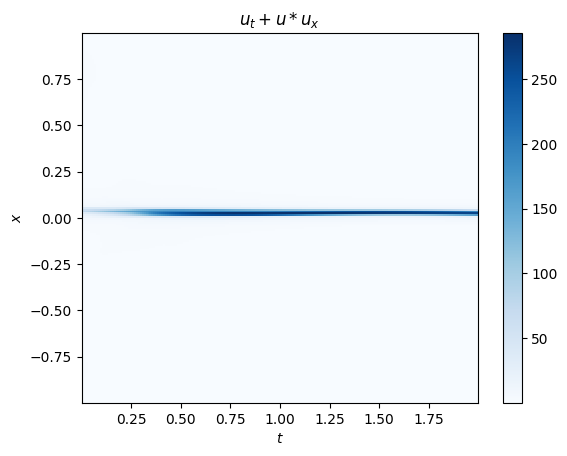

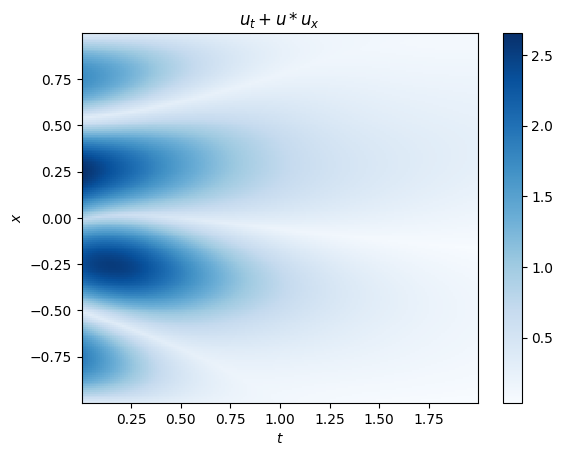

In [78]:
model1 = "../trained_models/pinn-burgers.pt"
model2 = "../trained_models/pinn-burgers_weak.pt"
partitions = 200
visualize_per_partition_bounds(model1, partitions)
visualize_per_partition_bounds(model2, partitions)